# Basic Flood Inundation Mapping using Height Above Nearest Drainage

**Authors:**  
   - Tony Castronova <acastronova@cuahsi.org>    
   - Irene Garousi-Nejad <igarousi@cuahsi.org>  
    
**Last Updated:** 05.22.2024

**Description**:  

The purpose of this Jupyter Notebook is to demonstrate the process of generating flood inundation maps (FIM) using pre-computed Height Above Nearest Drainage (HAND) raster maps. This process has been developed by the NOAA Office of Water Prediction, see the [inundation-mapping project](https://github.com/NOAA-OWP/inundation-mapping) for more information. 

There are two approaches to using the data provided by NOAA OWP to compute FIM; basic (simplified) mapping and mosaic mapping. The latter represents the state of practice in this domain, however for simplicity this notebook will demonstrate the former. After understanding the simplified approach it will be clear how to extend this work to the more complex *mosaic* methodology.

The FIM approach outlined in this notebook requires several input datasets. These can be obtained from the ESIP-hosted cloud store using the following commands (note: full instructions are provided in repository linked above):

```
aws s3 ls s3://noaa-nws-owp-fim/hand_fim/  

aws s3 sync s3://noaa-nws-owp-fim/hand_fim/outputs/fim_4_4_0_0/12090301 \
    /your_local_folder_name/12090301 
```

**Data Description**

- `rem_zeroed_masked_0.tif`: A geotif containing Height Above Nearest Drainage values.
- `gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg`: Vector data and attributes for river reaches.
- `demDerived_reaches_split_filtered_addedAttributes_crosswalked_0.gpkg`: DEM-derived reach geometries that will be used for visualization.
- `hydroTable_0.csv`: A comma separated file containing pre-computed stage-discharge values for every reach in the `demDerived` dataset.

**Software Requirements**:  

The software and operating system versions used to develop this notebook are listed below. To avoid encountering issues related to version conflicts among Python packages, we recommend creating a new environment variable and installing the required packages specifically for this notebook.

> dask-core: 2023.4.0  
  geopandas: 0.12.2   
  ipyleaflet: 0.17.2  
  matplotlib: 3.7.1   
  numpy: 1.24.2  
  pandas: 2.0.0  
  scipy: 1.10.1  
  xarray: 2023.4.1  
  pynhd: 0.16.3  
  geocube: 0.5.1  
  sidecar: 0.7.0  
  rioxarray: 0.15.3  
  
**Supplementary Code**

To simplify this notebook several *helper* functions have been develop that are referenced. These functions are located in a module called `nwm_utils`.

In [1]:
import numpy
import xarray
import rioxarray
import geopandas
import numpy as np
import pandas as pd
from typing import Dict
from pathlib import Path
from scipy import interpolate
import matplotlib.pyplot as plt
from geocube.api.core import make_geocube
from geocube.vector import vectorize

from sidecar import Sidecar
import ipyleaflet

In [2]:
from nwm_utils.fim import map, xfim, utils

Load the `DEM Derived` reaches that have been computed by the NOAA/OWP and load them onto an interactive map. A utility library (`nwm_utils.fim.map`) is used to simplify this process.

In [3]:
# Load DEM reaches using GeoPandas
geodf_reaches = geopandas.read_file(Path('./sample-data/demDerived_reaches_split_filtered_addedAttributes_crosswalked_0.gpkg'))
transformed_reaches = geodf_reaches.to_crs(epsg='4326')

In [4]:
# Create an interactive map using SideCar
sc = map.SideCarMap(gdf=transformed_reaches)
sc.display_map()

Creating Base Map...0.01 sec
Adding USGS Gages...0.00 sec
Adding NHD+ Reaches...0.00 sec
Adding Geopandas Features...19.46 sec
Rendering Map...1.81 sec


Now we need to select an area of interest on the map. Once a reach has been selected, the following cell can be executed to get its metadata.

In [5]:
nhd_feature_id = sc.selected().feature_id
sc.selected()

S0                                                     0.005691
LengthKm                                               1.463675
LakeID                                                   -999.0
HydroID                                                15854711
From_Node                                                  5998
To_Node                                                    5999
NextDownID                                             15854712
feature_id                                              2092277
order_                                                        1
areasqkm                                                 1.9197
ManningN                                                   0.06
geometry      LINESTRING (-84.11316772325351 38.432211621153...
Name: 4681, dtype: object

Next we need to define the streamflow to use to compute the flood inundation. This can be a hypothetical streamflow for now, but lets look at the stage-discharge relationships defined in the `hydroTable.csv` file to choose a reasonable value. Note, this can be easily replaced with logic to compute streamflow based on historical flows.

The reach that we selected in the map is subdivided into multiple segments, each having a unique stage-discharge relationship. Let's use a utility function to plot these relationships.

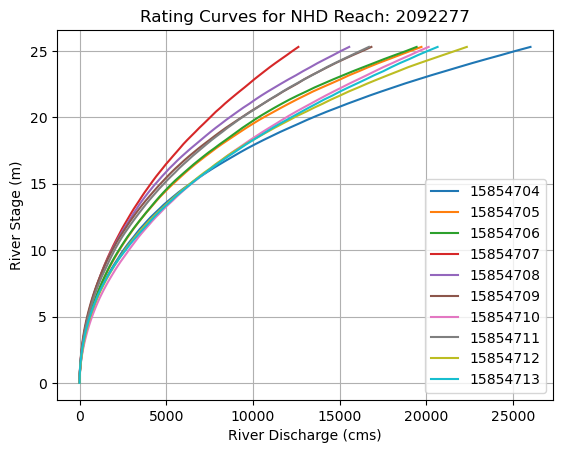

In [6]:
fig, ax = plt.subplots()


# collect the hydroids for all the segments within the selected reach.
d = utils.get_hydroids_for_reach(nhd_feature_id, hydrotable=Path('sample-data/hydroTable_0.csv'))

# get unique combos of HydroID and NextDownID
hydro_ids = np.unique(d.HydroID)
hydro_ids

# read the rating curve data
hydrotable = pd.read_csv('sample-data/hydroTable_0.csv',
                         usecols=["HydroID",
                                  "NextDownID",
                                  "feature_id",
                                  "stage",
                                  "discharge_cms"])

# collect rating curve data for each hydroid and plot
for hydro_id in hydro_ids:
    dat = hydrotable.loc[hydrotable.HydroID == hydro_id, ["stage", "discharge_cms"]]
    dat.plot(x='discharge_cms', y='stage', label=hydro_id, ax=ax)

ax.set_xlabel('River Discharge (cms)')
ax.set_ylabel('River Stage (m)')
plt.title(f'Rating Curves for NHD Reach: {nhd_feature_id}')
plt.grid(True)


In [7]:
# hypothetical streamflow (cms).
# This can be replaced with a flow value gathered by a source of your choice
cms = 5000

Use the streamflow defined above to interpolate river stage from a rating curve for all hydroids that exist within this NHD+ reach. 

In [8]:
stage_dict = xfim.get_stage_for_all_hydroids_in_reach(int(nhd_feature_id), cms, hydrotable=Path('sample-data/hydroTable_0.csv'))
stage_dict

{15854704: 13.579176089180757,
 15854705: 14.483842115200002,
 15854706: 14.562322191579248,
 15854707: 16.493390425416784,
 15854708: 15.893827106332134,
 15854709: 15.45566227850131,
 15854710: 13.273998160684773,
 15854711: 15.184852189191398,
 15854712: 13.45366932450942,
 15854713: 13.3753019682213}

Load the precomputed HAND raster.

In [9]:
xds = rioxarray.open_rasterio(Path('sample-data/rem_zeroed_masked_0.tif'),
                              masked=True).squeeze().drop_vars('band').to_dataset(name='hand')
xds

<xarray.Dataset> Size: 1GB
Dimensions:      (x: 18146, y: 17087)
Coordinates:
  * x            (x) float64 145kB 9.684e+05 9.684e+05 ... 1.15e+06 1.15e+06
  * y            (y) float64 137kB 1.85e+06 1.85e+06 ... 1.679e+06 1.679e+06
    spatial_ref  int64 8B 0
Data variables:
    hand         (y, x) float32 1GB ...

Make a copy of the 'hand' variable to the 'stage' variable. This will be used to compute the flood inundation map later on. The dataset will now have both `hand` and `stage` variables for all (x,y) locations.

In [10]:
xds['stage'] = xds.hand.copy(deep=True)
xds

<xarray.Dataset> Size: 2GB
Dimensions:      (x: 18146, y: 17087)
Coordinates:
  * x            (x) float64 145kB 9.684e+05 9.684e+05 ... 1.15e+06 1.15e+06
  * y            (y) float64 137kB 1.85e+06 1.85e+06 ... 1.679e+06 1.679e+06
    spatial_ref  int64 8B 0
Data variables:
    hand         (y, x) float32 1GB ...
    stage        (y, x) float32 1GB ...

Read watershed geometries and set stage values from the `stage_dict` defined above, and remove all other geometries. The end product will be a geodataframe containing the geometries for each `hydroid` in our area of interest and their stage values.

In [11]:
geodf = geopandas.read_file(Path('sample-data/gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg'))

# loop over each reach and set the corresponding stage
# in the geopandas object
for hydroid, stage in stage_dict.items():
    geodf.loc[geodf.HydroID==hydroid, 'stage'] = stage

# remove all nan values to make our dataset smaller
geodf_filtered = geodf[geodf.stage.notnull()]

# isolate only reaches we're interested in to make our dataset smaller
geodf_reaches_filtered = geodf_reaches[geodf_reaches.feature_id == nhd_feature_id]

geodf_filtered

,HydroID,S0,LengthKm,LakeID,From_Node,To_Node,NextDownID,areasqkm,feature_id,order_,src_calibrated,geometry,stage
1748,15854711,0.005691,1.463675,-999.0,5998,5999,15854712,1.9197,2092277,1,False,"POLYGON ((1025489.409 1776654.282, 1025499.409...",15.184852
1788,15854710,0.007042,1.472965,-999.0,5997,5998,15854711,1.4701,2092277,1,False,"POLYGON ((1025349.409 1775604.282, 1025359.409...",13.273998
1797,15854713,0.006180,1.417401,-999.0,6000,1684,15850332,4.2542,2092277,1,False,"POLYGON ((1025989.409 1778704.282, 1026029.409...",13.375302
1801,15854712,0.010306,1.461249,-999.0,5999,6000,15854713,5.4906,2092277,1,False,"POLYGON ((1025409.409 1777914.282, 1025439.409...",13.453669
1906,15854709,0.003788,1.462548,-999.0,5996,5997,15854710,3.2395,2092277,1,False,"POLYGON ((1025779.409 1774694.282, 1025829.409...",15.455662
1909,15854707,0.003922,1.464680,-999.0,5994,5995,15854708,0.9105,2092277,1,False,"POLYGON ((1026969.409 1774414.282, 1027009.409...",16.493390
1939,15854708,0.005176,1.470244,-999.0,5995,5996,15854709,1.8945,2092277,1,False,"POLYGON ((1025829.409 1774684.282, 1025839.409...",15.893827
1991,15854705,0.005619,1.471960,-999.0,5992,5993,15854706,2.4171,2092277,1,False,"POLYGON ((1029159.409 1773624.282, 1029169.409...",14.483842
2014,15854706,0.005597,1.462965,-999.0,5993,5994,15854707,3.7014,2092277,1,False,"POLYGON ((1028189.409 1774054.282, 1028209.409...",14.562322
2089,15854704,0.010564,1.464264,-999.0,5991,5992,15854705,1.9238,2092277,1,False,"POLYGON ((1029369.409 1772254.282, 1029439.409...",13.579176


Visualize the area that we're working with.

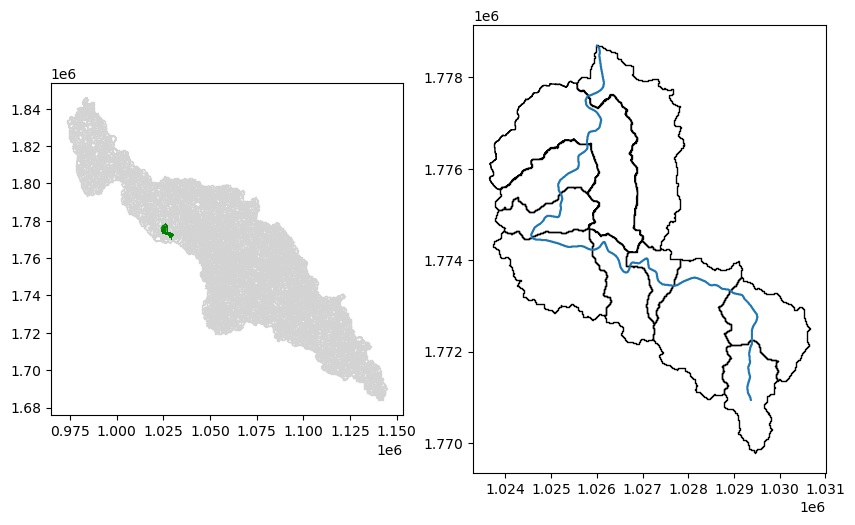

In [12]:
figure, axes = plt.subplots(1, 2, figsize=(10, 10))

geodf.plot(facecolor='None', edgecolor='lightgrey', ax=axes[0]);
geodf_filtered.plot(facecolor='green', ax=axes[0]);

geodf_filtered.plot(facecolor='None', ax=axes[1]);
geodf_reaches_filtered.plot(ax=axes[1]);

Add the geometries for our area of interest to the Xarray Dataset containing `hand` and `stage` variables using a GeoCube. This will enable us to set grid values corresponding with catchment areas.

In [13]:
# create a grid for the geocube
out_grid = make_geocube(
    vector_data=geodf,
    measurements=['HydroID'],
    like=xds # ensure the data are on the same grid
)

# add stage and hydroID to the HAND raster
ds = xds.assign_coords( hydroid = (['y', 'x'], out_grid.HydroID.data) )

# drop everything except the HydroIDs that we're interested in
ds = ds.where(ds.hydroid.isin(geodf_filtered.HydroID), drop=True)
ds

<xarray.Dataset> Size: 10MB
Dimensions:      (y: 892, x: 701)
Coordinates:
  * x            (x) float64 6kB 1.024e+06 1.024e+06 ... 1.031e+06 1.031e+06
  * y            (y) float64 7kB 1.779e+06 1.779e+06 ... 1.77e+06 1.77e+06
    spatial_ref  int64 8B 0
    hydroid      (y, x) float64 5MB 1.585e+07 1.585e+07 ... 1.585e+07 1.585e+07
Data variables:
    hand         (y, x) float32 3MB nan nan nan nan nan ... nan nan nan nan nan
    stage        (y, x) float32 3MB nan nan nan nan nan ... nan nan nan nan nan

Update the stage values in the DataSet where specific hydroid's exist.

In [14]:
for idx, row in geodf_filtered.iterrows():
    print(f'{row.HydroID} -> {row.stage}' )
    ds['stage'] = xarray.where(ds.hydroid == row.HydroID, row.stage, ds.stage)

15854711 -> 15.184852189191398
15854710 -> 13.273998160684773
15854713 -> 13.3753019682213
15854712 -> 13.45366932450942
15854709 -> 15.45566227850131
15854707 -> 16.493390425416784
15854708 -> 15.893827106332134
15854705 -> 14.483842115200002
15854706 -> 14.562322191579248
15854704 -> 13.579176089180757


Preview the `stage` data we set as well as the original `hand` data. 

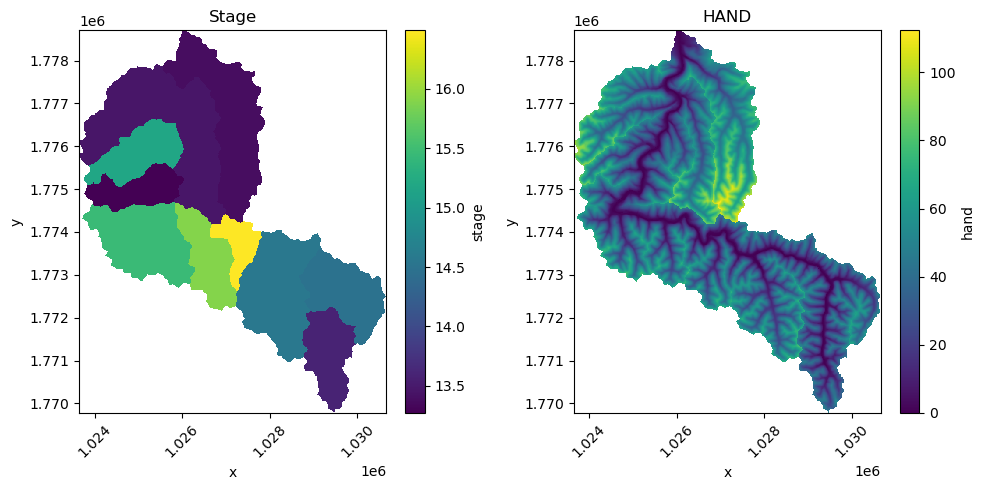

In [15]:
figure, axes = plt.subplots(1, 2, figsize=(10,5))

# plot stage
ds.stage.plot(ax=axes[0])
axes[0].set_title('Stage');
axes[0].tick_params(axis='x', labelrotation=45)

# plot hand
ds.hand.plot(ax=axes[1])
axes[1].set_title('HAND');
axes[1].tick_params(axis='x', labelrotation=45)

figure.tight_layout()


Compute FIM by subtracting `hand` from `stage`. Everything that is negative should be set to zero. Cells that have a value greater than zero indicate areas in which flooding occurs. Create a new variable in our dataset (called `fim`) to store this result.

In [16]:
ds['fim'] = ds.stage - ds.hand
ds['fim'] = xarray.where(ds.fim >= 0.00001, ds.fim, numpy.nan)

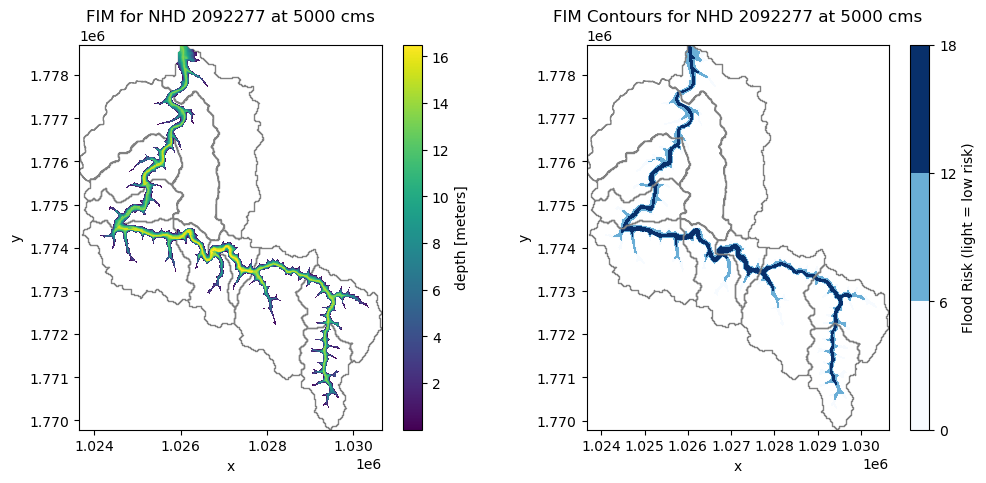

In [17]:
figure, axes = plt.subplots(1, 2, figsize=(12,5))

geodf.loc[geodf.feature_id==nhd_feature_id].plot(ax=axes[0], edgecolor='grey', facecolor='None');
ds.fim.plot(cbar_kwargs={'label':'depth [meters]'}, ax=axes[0]);
axes[0].set_title(f'FIM for NHD {nhd_feature_id} at {cms} cms');


xarray.plot.contourf(ds.fim, levels=4, cmap='Blues', cbar_kwargs={'label':'Flood Risk (light = low risk)'}, ax=axes[1]);
geodf.loc[geodf.feature_id==nhd_feature_id].plot(ax=axes[1], edgecolor='grey', facecolor='None');
axes[1].set_title(f'FIM Contours for NHD {nhd_feature_id} at {cms} cms');


In [18]:
# drop nans
da = ds.fim
df = vectorize(da)
df = df[df.fim.notna()]

In [19]:
transformed_fim = df.to_crs(epsg='4326')
poly = transformed_fim.dissolve()
poly.fim = 1

In [20]:
wlayer = ipyleaflet.WKTLayer(
            wkt_string=poly.iloc[0].geometry.wkt,
            style={'color': 'red', 'opacity':.5, 'weight':1.9,})
sc.map.add(wlayer);